# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function, unicode_literals

import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from torch.autograd import Variable
from torchvision import transforms, models, datasets

In [3]:
plt.ion()
mpl.rc_file_defaults()

In [4]:
input_size = 224

gpu_device = 0

load_trained = True
save_trained = True

# Choose your hyper-parameters using validation data
batch_size = 50
num_epochs = 100
hyp_momentum = 0.9
learning_rate =  0.001

## Helper Functions

In [5]:
def intersection_over_union(rec1, rec2):
    loc1, ws1 = rec1
    loc2, ws2 = rec2
    
    dx = min(loc1[0] + ws1[0], loc2[0] + ws2[0]) - max(loc1[0], loc2[0])
    dy = min(loc1[1] + ws1[1], loc2[1] + ws2[1]) - max(loc1[1], loc2[1])
    
    a1 = ws1[0] * ws1[1]
    a2 = ws2[0] * ws2[1]
    
    ai = max(dx, 0) * max(dy, 0)
    
    return ai / (a1 + a2 - ai)

## Build the data

Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.

In [6]:
%%bash

if [[ ! -d data ]]; then
    mkdir data

    wget -O data/train.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    wget -O data/test.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

    tar -xf data/train.tar -C data
    mv data/VOCdevkit/VOC2007 data/train
    rm -r data/VOCdevkit

    tar -xf data/test.tar -C data
    mv data/VOCdevkit/VOC2007 data/test
    rm -r data/VOCdevkit
fi

In [7]:
classes = ['aeroplane', 'background', 'bottle', 'chair']

num_classes = len(classes)

In [8]:
def build_dataset(root_dir, test=False):
    if test:
        path = os.path.join(root_dir, "processed", "all")
        if not os.path.exists(path):
            os.makedirs(path)
    else:    
        for c in classes:
            path = os.path.join(root_dir, "processed", c)
            if not os.path.exists(path):
                os.makedirs(path)

    images = glob(os.path.join(root_dir, "JPEGImages", "*.jpg"))

    if test:
        for img_path in images:
            img_name = img_path.split('/')[-1]
            
            img = cv2.imread(img_path)
            cv2.imwrite(os.path.join(root_dir, "processed/all", img_name), img)
    else:
        import xml.etree.ElementTree as ET
        
        background_patches = 0

        counts = { c: 1 for c in classes }
        for img_path in images:
            img_name = img_path.split('/')[-1].split('.')[0]

            ann_path = os.path.join(root_dir, "Annotations", img_name + ".xml")

            img = cv2.imread(img_path)

            tree = ET.parse(ann_path)
            root = tree.getroot()
            
            boxes = []

            for child in root:
                if child.tag == 'object' and child[0].tag == 'name':
                    c = child[0].text
                    
                    try:
                        coords = [int(child[4][i].text) for i in range(4)]
                        xmin, ymin, xmax, ymax = coords

                        boxes.append(((xmin - 1, ymin - 1), (xmax - xmin + 1, ymax - ymin + 1)))
                    except:
                        continue
                        
                    if c in classes:
                        cropped_img = img[ymin-1:ymax, xmin-1:xmax]
                        save_path = os.path.join(
                            root_dir, "processed", c, str(counts[c]) + ".jpg"
                        )

                        cv2.imwrite(save_path, cropped_img)

                        counts[c] += 1
                        
            if background_patches < 2500 and len(boxes) > 0:
                try:
                    xmin = np.random.randint(0, img.shape[1] - 50)
                    ymin = np.random.randint(0, img.shape[0] - 50)

                    xmax = np.random.randint(xmin + 50, img.shape[1])
                    ymax = np.random.randint(ymin + 50, img.shape[0])

                    bpatch = ((xmin, ymin), (xmax - xmin + 1, ymax - ymin + 1))
                    ious = [intersection_over_union(bpatch, box) for box in boxes]

                    if max(ious) < 0.1:
                        cropped_img = img[ymin:ymax+1, xmin:xmax+1]
                        save_path = os.path.join(
                            root_dir, "processed/background", str(background_patches + 1) + ".jpg"
                        )

                        cv2.imwrite(save_path, cropped_img)

                        background_patches += 1
                except:
                    pass

In [9]:
if False:
    build_dataset("./data/train")
    build_dataset("./data/test", test=True)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [10]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join("data", x, "processed"), None if x == "test" else data_transforms[x]
    ) for x in ["train", "test"]
}

def my_collate(batch):
    assert(len(batch) == 1)
    
    img, label = batch[0]
    
    return img, label

dataloaders_dict = {
    "train": torch.utils.data.DataLoader(
        image_datasets["train"], batch_size=batch_size,
        shuffle=True, num_workers=4
    ),
    "test": torch.utils.data.DataLoader(
        image_datasets["test"], batch_size=1,
        shuffle=False, num_workers=4, collate_fn=lambda x: x[0][0],
    )
}

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [11]:
device = torch.device(
    "cuda:%d" % (gpu_device)
    if torch.cuda.is_available() else "cpu"
)

In [12]:
class ResNet2(models.ResNet):
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        
        y = self.maxpool2(x)
        
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        
        x = torch.cat([x, y], dim=1)
        
        x = self.fc(x)

        return x

In [13]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth'
}

In [14]:
one_layer = False
train_full = False
        
if one_layer:
    resnet18 = models.resnet18(pretrained=True)
    
else:
    resnet18 = ResNet2(models.resnet.BasicBlock, [2, 2, 2, 2])
    resnet18.maxpool2 = nn.MaxPool2d(kernel_size=20, stride=10, padding=1)
    resnet18.load_state_dict(models.resnet.model_zoo.load_url(model_urls['resnet18']))
    
    resnet18.fc.in_features *= 2

if not train_full:
    for param in resnet18.parameters():
        param.requires_grad = False
    
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    
resnet18 = resnet18.to(device)

print("Parameters to Update:")

params_to_update = []
params_to_update_ = resnet18.named_parameters()

if not train_full:
    for name, param in params_to_update_:
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)

else:
    for name, param in params_to_update_:
        if param.requires_grad == True:
            print("\t", name)
        params_to_update.append(param)

Parameters to Update:
	 fc.weight
	 fc.bias


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, learning_rate, hyp_momentum)

In [16]:
#One Layer Detection
def train(model, data):
    model.train()
    
    epoch_len = len(data.dataset)
    
    with tqdm(range(num_epochs)) as bar:
        for _ in bar:
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in data:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(
                    torch.argmax(outputs, 1) == labels.data
                )
                
            bar.set_postfix({
                "loss": "%.4f" % (running_loss / epoch_len),
                "acc": "%.4f" % (running_corrects.double() / epoch_len)
            })

In [17]:
if load_trained:
    try:
        resnet18.load_state_dict(torch.load("saved_model.pt"))
    except:
        train(resnet18, dataloaders_dict["train"])
else:
    train(resnet18, dataloaders_dict["train"])

if save_trained:
    torch.save(resnet18.state_dict(), "saved_model.pt")

  1%|          | 1/100 [05:38<9:18:21, 338.40s/it, loss=0.8380, acc=0.6635]


KeyboardInterrupt: 

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [18]:
def sliding_window(img, step, ws):
    img = np.array(img)
    
    arr = []
    for y in range(0, img.shape[0], step):
        for x in range(0, img.shape[1], step):
            arr.append(((x, y), img[y:y + ws[1], x:x + ws[0]]))
            
            if len(arr) == 10:
                locs, imgs = zip(*arr)
                yield imgs, locs
                
                arr = []
                
    if len(arr) != 0:
        locs, imgs = zip(*arr)
        yield imgs, locs

In [19]:
def get_bounding_boxes(img):
    wss = [(50, 50)]
    
        for ws in wss:
        for patches, locs in sliding_window(img, int(min(ws) / 2), ws):
            patches = [Image.fromarray(patch) for patch in patches]
            patches = [data_transforms["test"](patch).numpy() for patch in patches]
            patches = torch.from_numpy(np.array(patches))
            
            patches = patches.to(device)
            
            probs = resnet18(patches)
            outs = torch.argmax(probs, 1).to("cpu").numpy()
            
            for i, out in enumerate(outs):
                if out != 2:
                    yield out, locs[i], ws,probs[i]

In [25]:
image_paths = glob("data/test/processed/all/*.jpg")

if one_layer:
    save_path = "data/predictions/one_layer"
else:
    save_path = "data/predictions/two_layer"
    
if not os.path.exists(save_path):
    os.makedirs(save_path)

for img_path in image_paths:
    img = Image.open(img_path)
    img_name = img_path.split('/')[-1].split('.')[0]
    
    %time boxes_ = list(get_bounding_boxes(img))
    
    with open(os.path.join(save_path, img_name + ".txt"), "w") as f:
        boxes = {c: [] for c in classes}
#         boxess = np.array(loc[0],loc[1],ws[0],ws[1])
#         print(boxess)
        for c, loc, ws,prob in boxes_:
            c = classes[c]

            boxes[c].append((loc, ws))
            print(c, loc[0], loc[1], ws[0], ws[1], file=f)
            
    
    break

CPU times: user 38.8 s, sys: 162 ms, total: 39 s
Wall time: 17 s


ValueError: only 2 non-keyword arguments accepted

In [21]:
draw = ImageDraw.Draw(img)
loc, ws = boxes["aeroplane"][2]
draw.rectangle([(loc[0], loc[1]), (loc[0] + ws[0], loc[1] + ws[1])])
del draw

IndexError: list index out of range

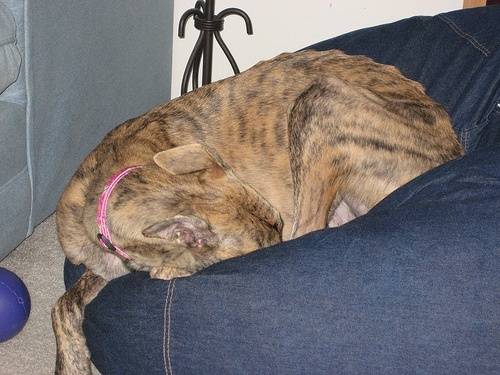

In [22]:
img

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [ ]:
def non_maximum_supression(boxes,scores,threshold = 0.3):
    assert boxes.shape[0] == scores.shape[0]
    # bottom-left origin
    ys1 = boxes[:, 0]
    xs1 = boxes[:, 1]
    # top-right target
    ys2 = boxes[:, 2]
    xs2 = boxes[:, 3]
    
    areas = (ys2 - ys1) * (xs2 - xs1)
    scores_indexes = scores.argsort().tolist()
    boxes_keep_index = []
    while len(scores_indexes):
        index = scores_indexes.pop()
        boxes_keep_index.append(index)
        if not len(scores_indexes):
            break
        ious = compute_iou(boxes[index], boxes[scores_indexes], areas[index],
                           areas[scores_indexes])
        filtered_indexes = set((ious > threshold).nonzero()[0])
        # if there are no more scores_index
        # then we should pop it
        scores_indexes = [
            v for (i, v) in enumerate(scores_indexes)
            if i not in filtered_indexes
        ]
    return np.array(boxes_keep_index)


def compute_iou(box, boxes, box_area, boxes_area):
    
    assert boxes.shape[0] == boxes_area.shape[0]

    ys1 = np.maximum(box[0], boxes[:, 0])
    xs1 = np.maximum(box[1], boxes[:, 1])
    ys2 = np.minimum(box[2], boxes[:, 2])
    xs2 = np.minimum(box[3], boxes[:, 3])

    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)

    unions = box_area + boxes_area - intersections

    ious = intersections / unions
    return ious


Test the trained model on the test dataset.

In [47]:
#expecting list of TP/FP (1,0)
from math import floor as f
def AP(TPFP): 
    size = len(TPFP)
    precision = []
    recall = []
    TPs = 0
    total_TPs = sum(TPFP)
    count = 1
    precision_inter = []
    max_precision = 0
    for e in TPFP:
        if e:
            TPs += 1
            max_precision = TPs/count
            precision.append(TPs/count)
            
        else:
            precision.append(TPs/count)
            if (TPs/count) > max_precision:
                max_precision = TPs/count
        recall.append(TPs/total_TPs)
        precision_inter.append(max_precision)
        count += 1
    area = 0
    for i in range(len(recall)):
        if i ==0:
            area += (1+f(10*recall[i]))*precision_inter[i]
        else:
            area += (f(10*recall[i])-f(10*recall[i-1]))*precision_inter[i-1]
    return area/11
X = [1,0,1,0,0,1,0]
Y = [1,0,0,1,1,0,0,1,1,0,0,1]
mAP = (AP(X) + AP(Y))/2
print(mAP)

0.7898989898989899


In [ ]:
%time test(resnet18)

In [ ]:
#Two Layer Detection
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)